# Predicting Future Sales

**Table of Contents**
* [Overview and Motivation](#overview)
* [Notebook setup](#notebooksetup)
* [1 Exploration and Cleaning](#section_1)
    * [1.1 Check Characteristic values](#section_1_1)
        * [1.1.1 Sales](#section_1_1_1)
        * [1.1.2 Items](#section_1_1_2)
        * [1.1.3 Categories](#section_1_1_3)
        * [1.1.4 Shops](#section_1_1_4)
    * [1.2 Check Key Figure values](#section_1_2)
        * [1.2.1 Normalise all data for further analysis](#section_1_2_1)
        * [1.2.2 Check Key Figure Values](#section_1_2_2) 
        * [1.2.3 Check item_price](#section_1_2_3) 
        * [1.2.4 Check item count](#section_1_2_4) 
        * [1.2.5 Item for Prediction](#section_1_2_5) 
    * [1.3. Exploratory Data Analysis](#section_1_3)
        * [1.3.1 General Sales Trend](#section_1_3_1)
        * [1.3.2 Items](#section_1_3_2)
        * [1.3.3 Shop](#section_1_3_3)
        * [1.3.4 Categories](#section_1_3_4)   
* [2. Feature Engineering](#section_2)
    * [2.1 Lag Features](#section_2_1)
    * [2.2 Rolling Window Features](#section_2_2)
    * [2.3 Expanding Window Features](#section_2_3)
* [3 Feature Selection](#section_3)
* [4 Forecast Model](#section_4)

## Abstract

Kaggle is an online community of data scientists and it offers machine learning competition. This study aims to resolve the “Predict Future Sales - Final project for How to win a data science competition Coursera course” Kaggle competition. The data set was provided by Russian software firms – 1C Company to do a prediction for November 2015 - total number of item count for each shops item - as required for final evaluation. In this study, multiple algorithms were utilized to do the prediction namely, XXX YYY ZZZZ. The results of the study, which is the performance of the prediction, suggest that XXX YYY prediction model is the most accurate and the authors propose that to include this algorithm/model to predict sales/item count 

## Overview and Motivation <a class="anchor" id="overview"></a>

Sales are the lifeblood of business. Business is not a charity organization but business focuses on sales which generates profit to the company.  The sales figures are the number that most bosses are hunting for. This is even crucial during pandemic times as what we are going through now. A lot of companies are closing down not because of the quality of product but due to the sales number. When sales are doing well, company might face out of stock issue. When sales are not doing well, company will have too much stock parking at the warehouse. Therefore, sales forecasting has increase its significance in business strategy so that the company does not have to spend too much on warehouse while not losing the customer loyalty. However, predicting future sales is quite challenging when we have insufficient data or with outlier data.  

Understanding the importance of sales forecasting, our group is lucky to find one competition in kaggle that will prepare us better to apply what we have learnt in our master study. The dataset that is provided in kaggle is similar like the data that we are able to find in the real world and we are glad that it is sufficient enough for us to perform the prediction. As it is a competition, it motivates us to even perform our best and evaluate how we are doing with the rest of the data scientist globally. 



## Notebook setup <a class="anchor" id="notebooksetup"></a>

In [1]:
from numpy import sqrt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import calmap
import math
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt # basic plotting
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns # for prettier plots
import statsmodels.api as sm


### Data Manipulation Options

You may change the value below to remove or keep the data as is <br>
REMOVE_NEGATIVE_COUNTS: Remove Negative item_cnt_day <br>
REMOVE_NEGATIVE_PRICE: Remove Negative item_price <br>
REMOVE_NON_PREDICT_ITM: Remove the item(s) that is not required for prediction <br>

Please note that changing these parameter will impact the some of the 
result below because some data set is removed after changing the value

In [2]:
REMOVE_NEGATIVE_COUNTS = True
REMOVE_NEGATIVE_PRICE = True
REMOVE_NON_PREDICT_ITM = True

## Exploration and Cleaning <a class="anchor" id="section_1"></a>

The below will read all the data set from csv files

sales - Daily historical data from January 2013 to October 2015. <br>
items - Supplemental information about the items/products.  <br>
categories - Supplemental information about the items categories.  <br>
shops - Supplemental information about the shops.  <br>
test - the sales for these shops and products for prediction (November 2015).  <br>

In [3]:
sales = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
categories = pd.read_csv("item_categories.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

Let's look at the data.

In [4]:
#check sales
sales.date.describe()
sales.sort_values(by='date')
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


### Check Characteristic values <a class="anchor" id="section_1_1"></a>

In this section, we will look into the data set mentioned in section 1 

**1.1.1 Sales** <a class="anchor" id="section_1_1_1"></a>

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


The above is the first 5 rows of the data and it appears tha there is a nagative value in the item_cnt_day. This will be handled in the section below. 

In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


The above shows the data type for the sales data set.

Check for null value

In [7]:
sales.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

<br>
From first 5 rows, we can already infer that there is data quality issue:

There is a negative value showing in the itm_cnt_day field. 

Let's remove the negative value if required (can be configure at the Data 
Manipulation Options section above)
<br>

In [8]:
if REMOVE_NEGATIVE_COUNTS:
    sales = sales[sales.item_cnt_day >= 0]

print()    
print("Total Number of rows for sales data frame: {}".format(len(sales))) 
print()
sales.head()


Total Number of rows for sales data frame: 2928493



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


Let's check whether sales have duplicate data 

In [9]:
print("number of duplicates : {}".format(
    sales.duplicated(subset=["date", "shop_id", "item_id"]).sum()))

checksales = sales[sales.duplicated(subset=["date", "shop_id", 
                                            "item_id"], keep=False)].copy()

checksales.sort_values(by = ["item_id","shop_id"])

number of duplicates : 26


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1496765,23.03.2014,14,21,3423,999.00,1.0
1496766,23.03.2014,14,21,3423,999.00,1.0
1866322,12.07.2014,18,25,3423,999.00,1.0
1866340,12.07.2014,18,25,3423,999.00,1.0
1435365,23.02.2014,13,50,3423,999.00,1.0
1435367,23.02.2014,13,50,3423,999.00,1.0
1671872,01.05.2014,16,50,3423,999.00,1.0
1671873,01.05.2014,16,50,3423,999.00,1.0
2272100,26.12.2014,23,17,3424,999.00,2.0
2272101,26.12.2014,23,17,3424,1199.00,1.0


Let's check whether all the duplicate data is required for prediction (appear in test.csv) or not.

In [10]:
testUniID = list(test.item_id.unique())

for idx in checksales.index:
    id = checksales.loc[idx, "item_id"]
    checksales.loc[idx, "Required"] = id in testUniID

#checksales[checksales.Required == False]
checksales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Required
6959,29.01.2013,0,25,12133,889.00,1.0,False
6960,29.01.2013,0,25,12133,1389.00,1.0,False
70686,25.01.2013,0,31,14050,349.00,1.0,False
70718,25.01.2013,0,31,14050,248.00,1.0,False
76961,05.01.2013,0,54,20130,149.00,1.0,False
76962,05.01.2013,0,54,20130,149.00,1.0,False
142696,18.02.2013,1,16,15702,149.00,1.0,True
142697,18.02.2013,1,16,15702,549.00,1.0,True
210156,16.02.2013,1,25,12133,1389.00,1.0,False
210173,16.02.2013,1,25,12133,889.00,1.0,False


It appears that the difference betweeen the duplicate data value doesn't deviate a lot comparing same item, therefore we will keep the duplicate data.

Let's check on the date format

In [11]:
sales.date.describe()

count        2928493
unique          1034
top       28.12.2013
freq            9415
Name: date, dtype: object

It appears that the the date is in wrong format. 

Let's convert the date to correct format

In [12]:
sales['date'] = pd.to_datetime(sales['date'], dayfirst = True)

sales.date.describe()

<ipython-input-12-996988f06957>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['date'] = pd.to_datetime(sales['date'], dayfirst = True)


count                 2928493
unique                   1034
top       2013-12-28 00:00:00
freq                     9415
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

The data is now in time stamp format

**1.1.2 Items** <a class="anchor" id="section_1_1_2"></a>

In this section, the item data set will be further explored. 

In [13]:
print()
print("Total Number of rows for items data frame: {}".format(len(items)))
print()
items.head()


Total Number of rows for items data frame: 22170



,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


Let's check whether there is dupilcate for item_name for Russian Name.

In [15]:
checkitems = items[items.duplicated(
    subset=["item_name", "item_category_id"], keep=False)].copy()

checkitems

,item_name,item_id,item_category_id


No duplication found for Russian item_name

**1.1.3 Categories** <a class="anchor" id="section_1_1_3"></a>

In this section, the categories set will be further explored.

In [16]:
print()
print("Total Number of rows for categories data frame: {}".format(len(categories))) 
print()
categories.head()


Total Number of rows for categories data frame: 84



,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


Let's check duplicates on the categories name

In [18]:
print("number of duplicates : {}".format(
    categories.duplicated(subset=["item_category_name"]).sum()))

number of duplicates : 0


**1.1.4 Shops** <a class="anchor" id="section_1_1_4"></a>

In this section, the shops set will be further explored.

In [19]:
print()
print("Number of rows for sales data frame : {:,.0f}".format(len(shops)))
shops.head()


Number of rows for sales data frame : 60


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [20]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


<br>
Let's check duplicaton for shops
<br><br>

In [21]:
print("number of duplicates : {}".format(shops.duplicated().sum()))

number of duplicates : 0


### Check Key Figure values <a class="anchor" id="section_1_2"></a>

**1.2.1 Normalise all data for further analysis** <a class="anchor" id="section_1_2_1"></a>

To further analayse the data, all the data set will be joined: item categories, sales, shop id, item id.

In [22]:
normData = sales.merge(shops, how="left", on="shop_id")
normData = normData.merge(items, how="left", on="item_id")
normData = normData.merge(categories, how="left", on="item_category_id")
normData.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,2013-01-10,0,25,2564,349.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


In [23]:
normData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928493 entries, 0 to 2928492
Data columns (total 10 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   date_block_num      int64         
 2   shop_id             int64         
 3   item_id             int64         
 4   item_price          float64       
 5   item_cnt_day        float64       
 6   shop_name           object        
 7   item_name           object        
 8   item_category_id    int64         
 9   item_category_name  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 245.8+ MB


Check for null value

In [24]:
# Check whether there is null value or not
normData.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
shop_name             0
item_name             0
item_category_id      0
item_category_name    0
dtype: int64

**1.2.2 Check Key Figure Values** <a class="anchor" id="section_1_2_2"></a>

Let's have a general look on all the key figure.

In [25]:
normData.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06,2.928493e+06
mean,1.456976e+01,3.300295e+01,1.020028e+04,8.894664e+02,1.248337e+00,4.001635e+01
std,9.422952e+00,1.622543e+01,6.324396e+03,1.727498e+03,2.619586e+00,1.709811e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.477000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.355000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.569100e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


**1.2.3 Check item_price** <a class="anchor" id="section_1_2_3"></a>

In [26]:
normData.item_price.describe()

count    2.928493e+06
mean     8.894664e+02
std      1.727498e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

It appears that there is negative value for price. Let's explore furhter about the volume of the negative data. 

In [27]:
print("negatie value: ", sales[sales.item_price < 0].count())

negatie value:  date              1
date_block_num    1
shop_id           1
item_id           1
item_price        1
item_cnt_day      1
dtype: int64


**Depend on selection, the negative value will be delete.**

In [28]:
if REMOVE_NEGATIVE_PRICE:
    sales = sales[sales.item_price >= 0]

Let's put the item_pricing into a box plot

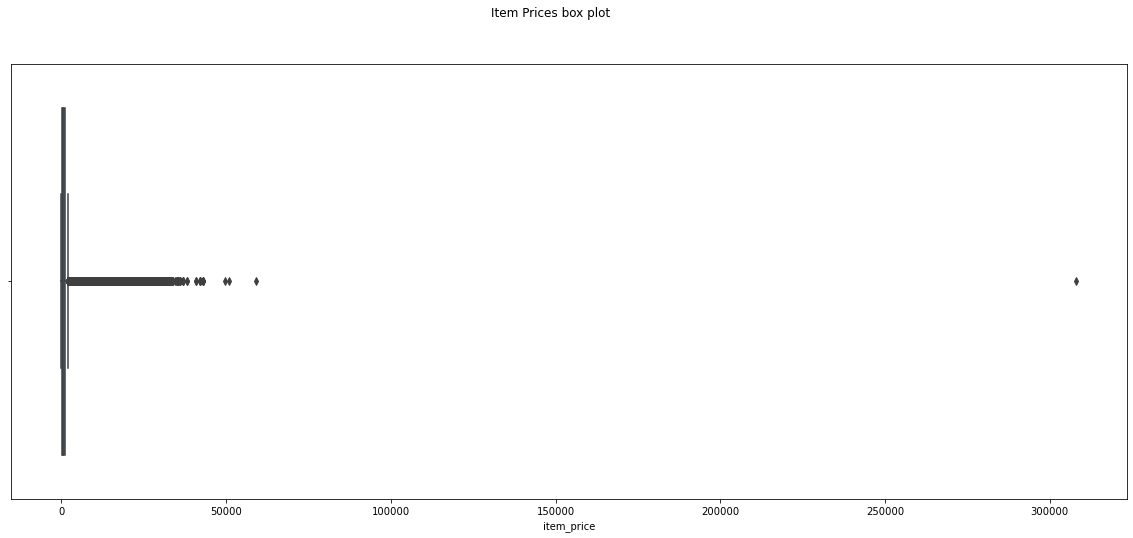

In [29]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices box plot")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

It seems that there is a extreme outlier especially hee sales_price higher than 300000. We will look further into the outliers. 

In [30]:
normData[normData.item_price >= 300000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1160360,2013-12-13,11,12,6066,307980.0,1.0,Интернет-магазин ЧС,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


Note: the result above will be empty if the remove parameter is set. 

It appears that there is only 1 item for item_price >= 300000. Let's check how many 6066 item_id in the data set. 

In [31]:
print("Number of record with item_id 6066: {}".format(len(normData[normData.item_id == 6066])))

Number of record with item_id 6066: 1


Only 1 record therefore we can definately delete the outlier. 

In [32]:
normData = normData[normData.item_price < 300000]

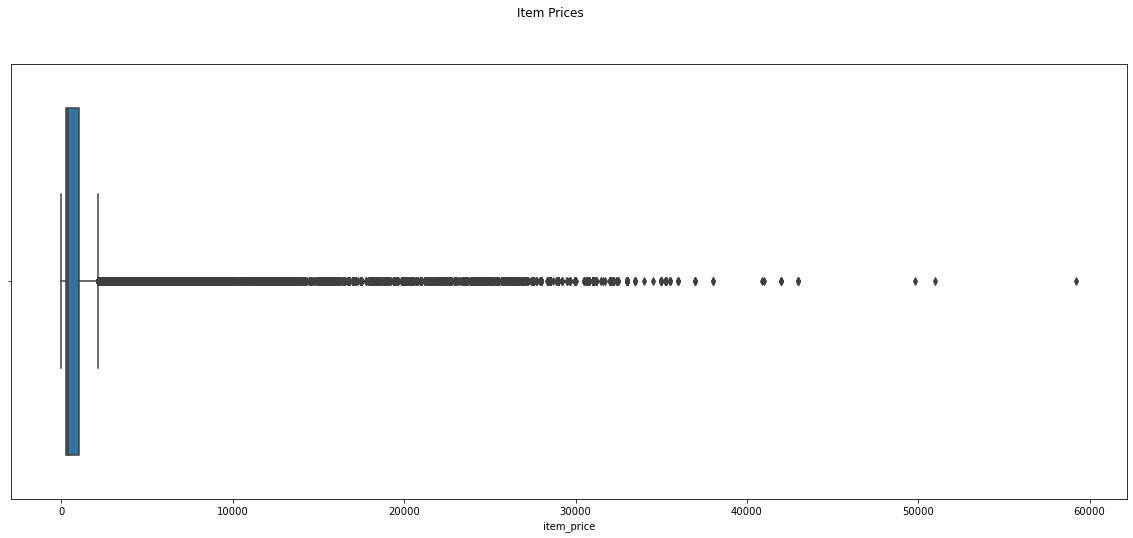

In [33]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Prices")
sns.boxplot(x=normData.item_price, ax=ax)
plt.show()

**1.2.4 Check item count** <a class="anchor" id="section_1_2_4"></a>

In the section below, we will look into item count

In [34]:
normData.item_cnt_day.describe()

count    2.928492e+06
mean     1.248337e+00
std      2.619586e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

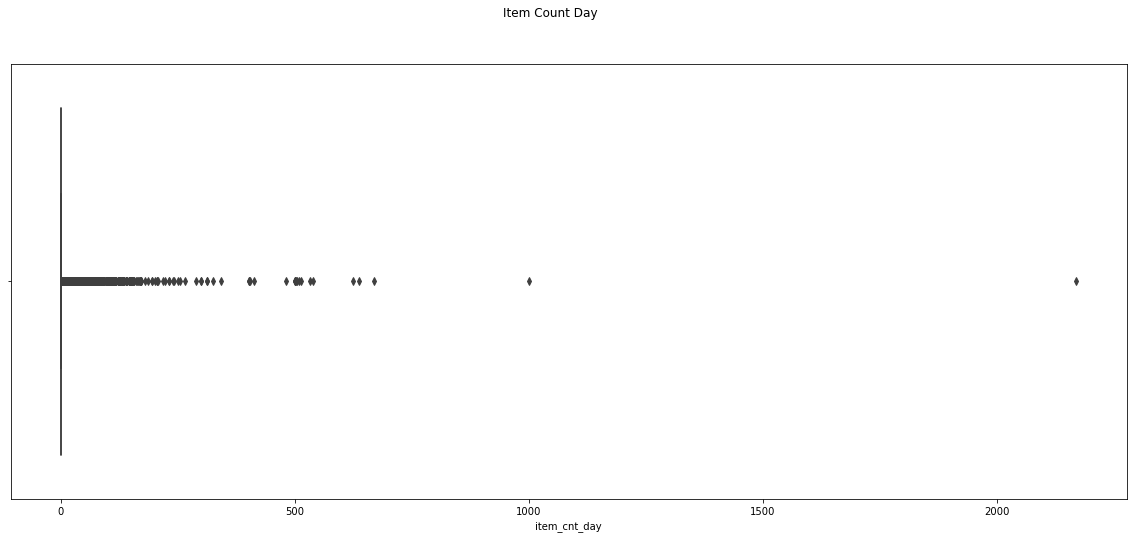

In [35]:
fig = plt.figure(figsize=(20, 8))
ax = plt.axes()
fig.suptitle("Item Count Day")
sns.boxplot(x=normData.item_cnt_day, ax=ax)
plt.show()

Let's check the outlier 

In [36]:
checkItemCnt = normData[normData.item_cnt_day >= 500]

checkItemCnt

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
1569319,2014-04-22,15,27,8057,1200.000000,502.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1703968,2014-06-28,17,25,20949,5.000000,501.0,"Москва ТРК ""Атриум""",Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2043436,2014-10-02,21,12,9242,1500.000000,512.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра)
2062536,2014-10-09,21,55,19437,899.000000,508.0,Цифровой склад 1С-Онлайн,"Средиземье: Тени Мордора [PC, Цифровая версия]",31,Игры PC - Цифра
2251731,2014-12-19,23,12,20949,4.000000,500.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2321202,2015-01-15,24,12,20949,4.000000,1000.0,Интернет-магазин ЧС,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши"
2601458,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2619552,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара
2843935,2015-09-29,32,55,9249,1500.000000,533.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра)
2843953,2015-09-30,32,55,9249,1702.825746,637.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра)


In the section below, we would like to check whether the outliers are included in the item list of the predicted/submission files.

In [37]:
for idx in checkItemCnt.index:
    id = checkItemCnt.loc[idx, "item_id"]
    checkItemCnt.loc[idx, "Required"] = id in testUniID

checkItemCnt.sort_values(by= "item_id")
    
#checkItemCnt[checkItemCnt.Required == True]

C:\Users\KANGHEA\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\KANGHEA\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,Required
2601458,2015-04-14,27,12,3731,1904.548077,624.0,Интернет-магазин ЧС,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания,True
1569319,2014-04-22,15,27,8057,1200.000000,502.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)",False
2043436,2014-10-02,21,12,9242,1500.000000,512.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2014"" (на один день (отдельно -...",8,Билеты (Цифра),False
2857064,2015-09-30,32,12,9248,1692.526158,669.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,False
2857089,2015-09-29,32,12,9248,1500.000000,504.0,Интернет-магазин ЧС,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,False
2843935,2015-09-29,32,55,9249,1500.000000,533.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),False
2843953,2015-09-30,32,55,9249,1702.825746,637.0,Цифровой склад 1С-Онлайн,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),False
2619552,2015-05-19,28,12,11373,155.192950,539.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара,True
2902517,2015-10-28,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара,True
2062536,2014-10-09,21,55,19437,899.000000,508.0,Цифровой склад 1С-Онлайн,"Средиземье: Тени Мордора [PC, Цифровая версия]",31,Игры PC - Цифра,False


It appears that some of the item_id do have high item_cnt_day number. 

Let's look further into 3731 and 8057 as they only have 1 rows

In [38]:
checkItemCnt = normData[normData.item_id == 3731]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
2547375,2015-04-30,27,29,3731,1999.000000,1.0,"Москва ТЦ ""Новый век"" (Новокосино)","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2761842,2015-07-19,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2761841,2015-07-15,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2761840,2015-07-04,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2761839,2015-07-02,30,34,3731,1999.000000,1.0,"Н.Новгород ТРЦ ""РИО""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
...,...,...,...,...,...,...,...,...,...,...
2598450,2015-04-14,27,18,3731,1930.034483,145.0,"Красноярск ТЦ ""Июнь""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2549338,2015-04-14,27,31,3731,1946.953216,171.0,"Москва ТЦ ""Семеновский""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2560953,2015-04-14,27,25,3731,1941.995169,207.0,"Москва ТРК ""Атриум""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания
2590468,2015-04-14,27,42,3731,1918.732441,299.0,"СПб ТК ""Невский Центр""","Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания


In [39]:
checkItemCnt = normData[normData.item_id == 8057]

checkItemCnt.sort_values(by = 'item_cnt_day')

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
805091,2013-08-24,7,28,8057,1500.0,1.0,"Москва ТЦ ""МЕГА Теплый Стан"" II",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1592489,2014-04-28,15,42,8057,1500.0,1.0,"СПб ТК ""Невский Центр""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1592490,2014-04-04,15,42,8057,1500.0,1.0,"СПб ТК ""Невский Центр""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1595835,2014-04-25,15,44,8057,1500.0,1.0,"Самара ТЦ ""Мелодия""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1627336,2014-05-24,16,27,8057,1500.0,1.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
...,...,...,...,...,...,...,...,...,...,...
2038085,2014-10-01,21,27,8057,1500.0,11.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1567473,2014-04-23,15,21,8057,1200.0,100.0,"Москва МТРЦ ""Афи Молл""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1614865,2014-04-23,15,29,8057,1200.0,240.0,"Москва ТЦ ""Новый век"" (Новокосино)",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"
1569318,2014-04-23,15,27,8057,1200.0,401.0,"Москва ТЦ ""МЕГА Белая Дача II""",iTunes 1500 руб.,32,"Карты оплаты (Кино, Музыка, Игры)"


Based on the section above, it appears item_cnt_day for 3731 and 8057 outliers is not a one off number. Potentially they have good sales during some days. Therefore we will keep the outliers


In [40]:
print("Number of Distinct Item: " + str(len(pd.unique(normData['item_id']))))
print("Number of Distinct Item Catgory: " + str(len(pd.unique(normData['item_category_id']))))
print("Number of Distinct Shop ID: " + str(len(pd.unique(normData['shop_id']))))

Number of Distinct Item: 21803
Number of Distinct Item Catgory: 84
Number of Distinct Shop ID: 60


**1.2.5 Item for Prediction** <a class="anchor" id="section_1_2_5"></a>

Only specific item need to be predict for the submission file. 

**Will be filtered depending on filter parameter selection**

In [41]:
if REMOVE_NON_PREDICT_ITM: 
    testUniID = list(test.item_id.unique())

    for idx in items.index:
        id = items.loc[idx, "item_id"]
        items.loc[idx, "Required"] = id in testUniID
# pre merge to removed data that are not related for prediction
# will drop the "Required" column for cleaner data. 
    sales = sales.merge(items, how="left", on="item_id")
    
    sales = sales[sales.Required == True]
    
# Drop column for cleaner data
    sales = sales.iloc[:, 0:6]

### Exploratory Data Analysis <a class="anchor" id="section_1_3"></a>

First we will need to add date related new columns for better analysis 

In [42]:
normData['date_month'] = normData['date'].dt.month
normData['date_year'] = normData['date'].dt.year
#Calculate total normData
normData['total_sales'] =  normData['item_price'] * normData['item_cnt_day']

Prepare the sales year split by year for reusability

**Run code below to get the cleaned data as CSV**

In [ ]:
#Save data as CSV file for analysis

normData.to_csv('predictFutureSalesClean.csv') 

In [ ]:
sales2013 = normData[normData['date_year'] == 2013]
sales2014 = normData[normData['date_year'] == 2014]
sales2015 = normData[normData['date_year'] == 2015]

The code above is to slice the data set to import data processing.

**1.3.1 General Sales Trend** <a class="anchor" id="section_1_3_1"></a>

In [ ]:
# Find aggregate sales by day
salesMonYea2013 = sales2013.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2014 = sales2014.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()
salesMonYea2015 = sales2015.groupby(['date_month','date_year'])[['total_sales']].agg('sum').reset_index()

totalSales = pd.concat([salesMonYea2013,salesMonYea2014,salesMonYea2015])

In [ ]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'total_sales', data = totalSales,
           hue='date_year', palette = 'Accent')

plt.title("Total Sales", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

Let's look at the heatmap for sales trend

In [ ]:
calHeatMap = normData[["date", "item_cnt_day"]]

calHeatMap.set_index("date", inplace = True)

calHeatMap = calHeatMap.resample("D")["item_cnt_day"].sum()

calmap.calendarplot(calHeatMap, # pass the series
                    fig_kws = {'figsize': (16,10)}, 
                    cmap='YlGn',
                    fillcolor='grey',
                    yearlabel_kws = {'color':'black', 'fontsize':14}, 
                    subplot_kws = {'title':'Total sales per year'}
                   );

In [ ]:
all_data = normData
all_data['date'] = pd.to_datetime(all_data.date, format='%Y.%m.%d')
all_data['date_week'] = all_data.date.dt.week
all_data['dayofweek_name'] = all_data.date.dt.day_name()
all_data['dayofweek_no'] = all_data.date.dt.dayofweek 
all_data['wrk_week'] = np.where(all_data['date_year']==2013, all_data['date_week'], np.where(all_data['date_year']==2014, all_data['date_week']+52, all_data['date_week']+104))

In [ ]:
sales.dtypes

In [ ]:
#sort the values on date, shop_id and item_id
all_data = all_data.sort_values(by=['date', 'shop_id', 'item_id'])

In [ ]:
#plot daily line graph from jan 2013 to oct 2015
all_data_by_date = all_data[['date', 'total_sales']]

aggregations = {'total_sales':'sum'}
all_data_by_date = all_data_by_date.groupby(['date'], as_index=False).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)

ax = all_data_by_date.plot(x='date', y='total_sales', kind='line', figsize=(20,5))
ax.set_title('Total Daily Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Daily)")
ax.set_ylabel("Total Sales")

The above shows the sales trend from 2013 until 2015. We could observe that there is a daily spike trend for end of year.

In [ ]:
#plot weekly line graph from jan 2013 to oct 2015
all_data_by_week = all_data[['date', 'total_sales', 'date_week', 'date_year']]
#all_data_working

aggregations = {'total_sales':'sum'}
all_data_by_week = all_data_by_week.groupby(['date_year', 'date_week']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
#all_data_by_week
ax = all_data_by_week['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Weekly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Week)")
ax.set_ylabel("Total Sales")

The above is the sales trend by week. 

In [ ]:
#plot weekly graph by year for better comparison
all_data_by_week = all_data.groupby(['date_week', 'date_year'])[['total_sales']].agg('sum').reset_index()
#all_data_agg


plt.rcParams['figure.figsize']=(20, 5)
sns.lineplot(x='date_week', y='total_sales', hue='date_year', data = all_data_by_week, palette='Accent')
plt.title("Total Weekly Sales from Jan 2013 to Oct 2015", fontsize = 20)
plt.xlabel("Jan 2013 to Oct 2015 (Week)", fontsize = 15)
plt.ylabel("Total Sales", fontsize = 15)
#plt.figure(figsize=(100, 6))
plt.show()

In [ ]:
#plot monthly line graph from jan 2013 to oct 2015
all_data_by_month = all_data[['date', 'total_sales', 'date_month', 'date_year']]
#all_data_working

aggregations = {'total_sales':'sum'}
all_data_by_month = all_data_by_month.groupby(['date_year', 'date_month']).agg(aggregations)
pd.set_option('display.float_format', '{:20,.2f}'.format)
#all_data_by_week
ax = all_data_by_month['total_sales'].plot(figsize=(20,5))
ax.set_title('Total Monthly Sales from Jan 2013 to Oct 2015')
ax.set_xlabel("Jan 2013 to Oct 2015 (Month)")
ax.set_ylabel("Total Sales")

The above is the monthly sales. 

Let's check item count trend as well

In [ ]:
# Find aggregate sales by day
itemCntYea2013 = sales2013.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2014 = sales2014.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()
itemCntYea2015 = sales2015.groupby(['date_month','date_year'])[['item_cnt_day']].agg('sum').reset_index()

itemCntYea = pd.concat([itemCntYea2013,itemCntYea2014,itemCntYea2015])

In [ ]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_month', y = 'item_cnt_day', data = itemCntYea,
           hue='date_year', palette = 'Accent')

plt.title("Total Item Count", fontsize = 20)
plt.xlabel("Month", fontsize = 15)
plt.ylabel("Total Item Count", fontsize = 15)
legend = ax0.legend()
legend.texts[0].set_text("Year")
plt.show()

**1.3.2 Items** <a class="anchor" id="section_1_3_2"></a>

In the section below, we will look further into the items data. 

In [ ]:

item_sales = normData.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()

item_sales

Let's explore the graph for Top 10 Total Sales by Item

In [ ]:
def buildItemSalesGraph(df,ax0,year):
    
    item_sales = df.groupby(['item_id'])[['total_sales']].agg('sum').reset_index()
    
    item_sales = item_sales.sort_values(by=['total_sales'], ascending =False)

    item_sales = item_sales.head(n = 10)
    
    axTotal= sns.barplot(ax=ax0, x = item_sales.item_id, 
                y = item_sales.total_sales,
               order= item_sales.sort_values('total_sales').item_id,
                color = 'lightsteelblue')
   
    if year == '':
        axTotal.title.set_text('Top 10 Item by Sales for All Years')
    else: 
        title = 'Top 10 Item by Sales ' + str(year)
        axTotal.title.set_text(title)
    
    axTotal.set_xlabel('Item ID')
    axTotal.set_ylabel('Total Sales')
    axTotal.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemSalesGraph(normData,axes[0,0],'')
buildItemSalesGraph(sales2013,axes[0,1],2013)
buildItemSalesGraph(sales2014,axes[1,0],2014)
buildItemSalesGraph(sales2015,axes[1,1],2015)

Let's explore the graph for Top 10 Total Sales by Item

In [ ]:
def buildItemCntGraph(df,ax0,year):

    sales_item_cnt = df.groupby(['item_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_item_cnt = sales_item_cnt.sort_values(by=['item_cnt_day'], ascending =False)

    sales_item_cnt = sales_item_cnt.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_item_cnt.item_id, 
                y = sales_item_cnt.item_cnt_day,
               order=sales_item_cnt.sort_values('item_cnt_day').item_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Item by Count for All Years')
    else: 
        title = 'Top 10 Item by Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item ID')
    ax.set_ylabel('Total Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)
    
# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildItemCntGraph(normData,axes[0,0],'')
buildItemCntGraph(sales2013,axes[0,1],2013)
buildItemCntGraph(sales2014,axes[1,0],2014)
buildItemCntGraph(sales2015,axes[1,1],2015)

**1.3.3 Shop** <a class="anchor" id="section_1_3_3"></a>

In the section below, we will look further into the shop data.

In [ ]:
# Checking Shop with top 10 Sales
# Prepare subplots
def buildShopSalesGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['total_sales']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['total_sales'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.total_sales,
               order=sales_shop.sort_values('total_sales').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Sales for All Years')
    else: 
        title = 'Top 10 Shop by Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

buildShopSalesGraph(normData,axes[0,0],'')
buildShopSalesGraph(sales2013,axes[0,1],2013)
buildShopSalesGraph(sales2014,axes[1,0],2014)
buildShopSalesGraph(sales2015,axes[1,1],2015)

In [ ]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildShopCntGraph(df,ax0,year):

    sales_shop = df.groupby(['shop_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_shop = sales_shop.sort_values(by=['item_cnt_day'], ascending =False)

    sales_shop = sales_shop.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_shop.shop_id, 
                y = sales_shop.item_cnt_day,
               order=sales_shop.sort_values('item_cnt_day').shop_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Shop ID')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildShopCntGraph(normData,axes[0,0],'')
buildShopCntGraph(sales2013,axes[0,1],2013)
buildShopCntGraph(sales2014,axes[1,0],2014)
buildShopCntGraph(sales2015,axes[1,1],2015)



**1.3.4 Categories** <a class="anchor" id="section_1_3_4"></a>

In the section below, we will look further into the categories data.

In [ ]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatSalesGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['total_sales']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['total_sales'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.total_sales,
               order=sales_cat.sort_values('total_sales').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Categories by Total Sales for All Years')
    else: 
        title = 'Top 10 Categories by Total Sales ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Total Sales')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatSalesGraph(normData,axes[0,0],'')
buildCatSalesGraph(sales2013,axes[0,1],2013)
buildCatSalesGraph(sales2014,axes[1,0],2014)
buildCatSalesGraph(sales2015,axes[1,1],2015)

In [ ]:
# Checking Top 10 shop with Item count
# Prepare subplots
def buildCatCntGraph(df,ax0,year):

    sales_cat = df.groupby(['item_category_id'])[['item_cnt_day']].agg('sum').reset_index()

    sales_cat = sales_cat.sort_values(by=['item_cnt_day'], ascending =False)

    sales_cat = sales_cat.head(n = 10)

    ax= sns.barplot(ax=ax0, x = sales_cat.item_category_id, 
                y = sales_cat.item_cnt_day,
               order=sales_cat.sort_values('item_cnt_day').item_category_id,
                   color = 'lightsteelblue')
    
    if year == '':
        ax.title.set_text('Top 10 Shop by Item Count for All Years')
    else: 
        title = 'Top 10 Shop by Item Count ' + str(year)
        ax.title.set_text(title)
    
    ax.set_xlabel('Item Category')
    ax.set_ylabel('Item Count')
    ax.yaxis.set_tick_params(labelbottom=True)

# Checking best item selling by sales - Top 10
# Prepare subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 10),sharey=True)

buildCatCntGraph(normData,axes[0,0],'')
buildCatCntGraph(sales2013,axes[0,1],2013)
buildCatCntGraph(sales2014,axes[1,0],2014)
buildCatCntGraph(sales2015,axes[1,1],2015)



In [ ]:
#reading data from file
train = pd.read_csv('predictFutureSalesClean.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

In [ ]:
#checking the data types of train
train.dtypes

## Feature Engineering  <a class="anchor" id="section_2"></a>

### Lag Features <a class="anchor" id="section_2_1"></a>

A lag value of 7 is being chosen to correlate of weekly trend

In [ ]:
#lag feature - to be used as the bases for machine learning

all_data_by_day = all_data
aggregations = {'total_sales':'sum'}
all_data_by_day = all_data_by_day.groupby(['date'], as_index=False).agg(aggregations)
all_data_by_day['lag_1'] = all_data_by_day['total_sales'].shift(1)
all_data_by_day['lag_2'] = all_data_by_day['total_sales'].shift(2)
all_data_by_day['lag_3'] = all_data_by_day['total_sales'].shift(3)
all_data_by_day['lag_4'] = all_data_by_day['total_sales'].shift(4)
all_data_by_day['lag_5'] = all_data_by_day['total_sales'].shift(5)
all_data_by_day['lag_6'] = all_data_by_day['total_sales'].shift(6)
all_data_by_day['lag_7'] = all_data_by_day['total_sales'].shift(7)
all_data_by_day

In [ ]:
#plot autocorrelation and partial autocorrelation
#autocorrelation is a measure of the correlation between the lagged values of a time series
#partial autocorrelation is the correlation that results after removing the effect of any correlations due to the terms at shorter lags
plot_acf(all_data_by_day['total_sales'])
plot_pacf(all_data_by_day['total_sales'])

### Rolling Window Features <a class="anchor" id="section_2_2"></a>

Rolling window feature is to calculate statistical value base on past values. In this example, we are using the statistical of 7 days (1 week) to work on the rolling window. 

In [ ]:
#construct the rolling mean of 7 days (1 week) compare with total sales
all_data_by_day['rolling_mean'] = all_data_by_day['total_sales'].rolling(window=7).mean()
all_data_by_day[['total_sales', 'rolling_mean']].plot(figsize=(20, 5))

In [ ]:
#construct the rolling mean and standard deviation of months compare with total sales
plt.rcParams['figure.figsize']=(20, 8)
all_data_by_day = all_data.groupby(['date']).agg(aggregations)
timeseries = all_data_by_day['total_sales']
timeseries.rolling(34).mean().plot(label='34 Months Rolling Mean')
timeseries.rolling(34).std().plot(label='34 Months Rolling Std')
timeseries.plot()
plt.legend()

### Expanding Window Features <a class="anchor" id="section_2_3"></a>
Expanding window feature is to take all the most recent values to calculate the mean. 7 days of mean is used in this calculation. 

In [ ]:
#construct the expanding mean of 7 days (1 week) compare with total sales
all_data_by_day['expanding_mean'] = all_data_by_day['total_sales'].expanding(7).mean()
all_data_by_day[['total_sales', 'expanding_mean']].plot(figsize=(20, 5))

## Feature Selection <a class="anchor" id="section_3"></a>

## Forecast Model <a class="anchor" id="section_4"></a>